In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings

# Dependency imports
from absl import flags
import matplotlib
import numpy as np
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import pickle 

from models.bayesian_resnet import bayesian_resnet
from models.bayesian_vgg import bayesian_vgg

matplotlib.use("Agg")
warnings.simplefilter(action="ignore")
tfd = tfp.distributions

IMAGE_SHAPE = [32, 32, 3]

In [2]:
def build_input_pipeline(x_train, x_test, y_train, y_test,
                         batch_size, valid_size):
  """Build an Iterator switching between train and heldout data."""
  x_train = x_train.astype("float32")
  x_test = x_test.astype("float32")

  x_train /= 255
  x_test /= 255

  y_train = y_train.flatten()
  y_test = y_test.flatten()

  if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

  print("x_train shape:" + str(x_train.shape))
  print(str(x_train.shape[0]) + " train samples")
  print(str(x_test.shape[0]) + " test samples")

  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices(
      (x_train, np.int32(y_train)))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  training_iterator = tf.compat.v1.data.make_one_shot_iterator(training_batches)

  # Build a iterator over the heldout set with batch_size=heldout_size,
  # i.e., return the entire heldout set as a constant.
  heldout_dataset = tf.data.Dataset.from_tensor_slices(
      (x_test, np.int32(y_test)))
  heldout_batches = heldout_dataset.repeat().batch(valid_size)
  heldout_iterator = tf.compat.v1.data.make_one_shot_iterator(heldout_batches)

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.compat.v1.placeholder(tf.string, shape=[])
  feedable_iterator = tf.compat.v1.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  images, labels = feedable_iterator.get_next()

  return images, labels, handle, training_iterator, heldout_iterator

In [3]:
def build_fake_data(num_examples):
  """Build fake CIFAR10-style data for unit testing."""
  num_examples = num_examples
  x_train = np.random.rand(num_examples, *IMAGE_SHAPE).astype(np.float32)
  y_train = np.random.permutation(np.arange(num_examples)).astype(np.int32)
  x_test = np.random.rand(num_examples, *IMAGE_SHAPE).astype(np.float32)
  y_test = np.random.permutation(np.arange(num_examples)).astype(np.int32)
  return (x_train, y_train), (x_test, y_test)

In [4]:
model_dir = "bnnmodels/"

### Hyperparams

In [5]:
#Generate fake data for now before switching to CIFAR10
fake_data = True
#batch_size = 128
data_dir = "data/"
eval_freq = 400
num_monte_carlo = 50
architecture = "resnet" # or "vgg"
kernel_posterior_scale_mean = 0.9
kernel_posterior_scale_constraint = 0.2
kl_annealing = 50
subtract_pixel_mean = True

In [6]:
from IPython.core.debugger import set_trace

In [7]:
def run_experiment(algo,fake_data, batch_size, epochs, learning_rate,verbose):
    with tf.Session() as sess:
        
        model_fn = bayesian_resnet
        #model_fn = bayesian_vgg
        model = model_fn(
            IMAGE_SHAPE,
            num_classes=10,
            kernel_posterior_scale_mean=kernel_posterior_scale_mean,
            kernel_posterior_scale_constraint=kernel_posterior_scale_constraint)
        logits = model(images)
        labels_distribution = tfd.Categorical(logits=logits)
        t = tf.compat.v2.Variable(0.0)
        kl_regularizer = t / (kl_annealing * len(x_train) / batch_size)

        log_likelihood = labels_distribution.log_prob(labels)
        neg_log_likelihood = -tf.reduce_mean(input_tensor=log_likelihood)
        kl = sum(model.losses) / len(x_train) * tf.minimum(1.0, kl_regularizer)
        loss = neg_log_likelihood + kl

        predictions = tf.argmax(input=logits, axis=1)

        with tf.compat.v1.name_scope("train"):
            train_accuracy, train_accuracy_update_op = tf.compat.v1.metrics.accuracy(
              labels=labels, predictions=predictions)
            if algo=="adam":
                opt = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
            if algo=="adagrad":
                opt = tf.compat.v1.train.AdagradOptimizer(learning_rate=learning_rate)
            if algo=="adadelta":
                opt = tf.compat.v1.train.AdadeltaOptimizer(learning_rate=learning_rate)
            if algo=="rmsprop":
                opt = tf.compat.v1.train.RMSPropOptimizer(learning_rate=learning_rate)

            train_op = opt.minimize(loss)
            update_step_op = tf.compat.v1.assign(t, t + 1)

        with tf.compat.v1.name_scope("valid"):
            valid_accuracy, valid_accuracy_update_op = tf.compat.v1.metrics.accuracy(
              labels=labels, predictions=predictions)

            init_op = tf.group(tf.compat.v1.global_variables_initializer(),
                           tf.compat.v1.local_variables_initializer())

            stream_vars_valid = [v for v in tf.compat.v1.local_variables() if "valid/" in v.name]
            reset_valid_op = tf.compat.v1.variables_initializer(stream_vars_valid)
    
    
   # with tf.compat.v1.Session() as sess:
        sess.run(init_op)

        # Run the training loop
        train_handle = sess.run(training_iterator.string_handle())
        heldout_handle = sess.run(heldout_iterator.string_handle())
        training_steps = int(
          round(epochs * (len(x_train) / batch_size)))
        
        listkl = []
        listloss = []
        listaccuracy = []
        print(training_steps)
        for step in range(training_steps):
            _ = sess.run([train_op,
                      train_accuracy_update_op,
                      update_step_op],
                     feed_dict={handle: train_handle})
            # Print loss values
            #set_trace()
            loss_value, accuracy_value, kl_value = sess.run(
                  [loss, train_accuracy, kl], feed_dict={handle: train_handle})
            print("Step: {:>3d} Loss: {:.3f} Accuracy: {:.3f} KL: {:.3f}".format(
                      step, loss_value, accuracy_value, kl_value))
            listkl.append(kl_value)
            listloss.append(loss_value)
            listaccuracy.append(accuracy_value)
        sess.run(reset_valid_op)
        

    return listloss,listkl
    

In [18]:
num_examples = 10
batch_size = 2
epochs = 30
nb_runs = 1
seed0 = 23456

In [19]:
with tf.Session() as sess:
    if fake_data:
        (x_train, y_train), (x_test, y_test) = build_fake_data(num_examples)
    else:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    (images, labels, handle,
     training_iterator,
     heldout_iterator) = build_input_pipeline(x_train, x_test, y_train, y_test,
                                              batch_size, 500)

x_train shape:(10, 32, 32, 3)
10 train samples
10 test samples


### ADAM

In [21]:
lr_adam = 0.001

In [22]:
adam = []
for _ in range(nb_runs):
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='adam', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_adam, 
                         verbose= True)
    adam.append(loss)

150
Step:   0 Loss: 23167.188 Accuracy: 0.000 KL: 2399.101
Step:   1 Loss: 77923.383 Accuracy: 0.000 KL: 4799.852
Step:   2 Loss: 112931.484 Accuracy: 0.000 KL: 7201.123
Step:   3 Loss: 119798.227 Accuracy: 0.125 KL: 9602.864
Step:   4 Loss: 54492.953 Accuracy: 0.200 KL: 12005.002
Step:   5 Loss: 271070.000 Accuracy: 0.167 KL: 14407.469
Step:   6 Loss: 181814.312 Accuracy: 0.143 KL: 16810.217
Step:   7 Loss: 33256.488 Accuracy: 0.125 KL: 19213.199
Step:   8 Loss: 153234.047 Accuracy: 0.111 KL: 21616.391
Step:   9 Loss: 156057.000 Accuracy: 0.100 KL: 24019.770
Step:  10 Loss: 236245.016 Accuracy: 0.091 KL: 26423.297
Step:  11 Loss: 148601.234 Accuracy: 0.083 KL: 28826.961
Step:  12 Loss: 57474.703 Accuracy: 0.077 KL: 31230.744
Step:  13 Loss: 180638.078 Accuracy: 0.071 KL: 33634.629
Step:  14 Loss: 111812.484 Accuracy: 0.067 KL: 36038.605
Step:  15 Loss: 162913.609 Accuracy: 0.062 KL: 38442.637
Step:  16 Loss: 142069.109 Accuracy: 0.059 KL: 40846.750
Step:  17 Loss: 232122.031 Accuracy:

Step: 143 Loss: 467975.656 Accuracy: 0.101 KL: 346264.812
Step: 144 Loss: 438983.250 Accuracy: 0.100 KL: 348670.281
Step: 145 Loss: 374117.406 Accuracy: 0.103 KL: 351075.625
Step: 146 Loss: 422770.562 Accuracy: 0.102 KL: 353481.031
Step: 147 Loss: 400707.719 Accuracy: 0.101 KL: 355886.531
Step: 148 Loss: 385417.969 Accuracy: 0.101 KL: 358292.031
Step: 149 Loss: 400598.812 Accuracy: 0.103 KL: 360697.438


In [40]:
##SAVE LOSSES
with open('losses/adam', 'wb') as fp: 
    pickle.dump(adam, fp)

In [ ]:
with open('losses/adam', 'wb') as fp: 
    pickle.dump(adam, fp)

## Adagrad

In [30]:
lr_adagrad = 0.001
adagrad = []
for _ in range(nb_runs):
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='adagrad', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_adagrad, 
                         verbose= True)
    adagrad.append(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
150
Step:   0 Loss: 129575.359 Accuracy: 0.000 KL: 2399.139
Step:   1 Loss: 238440.594 Accuracy: 0.000 KL: 4798.485
Step:   2 Loss: 27833.234 Accuracy: 0.000 KL: 7198.583
Step:   3 Loss: 157217.469 Accuracy: 0.000 KL: 9599.025
Step:   4 Loss: 64958.613 Accuracy: 0.000 KL: 11999.651
Step:   5 Loss: 76222.070 Accuracy: 0.000 KL: 14400.425
Step:   6 Loss: 24684.395 Accuracy: 0.000 KL: 16801.312
Step:   7 Loss: 177477.109 Accuracy: 0.062 KL: 19202.240
Step:   8 Loss: 332981.188 Accuracy: 0.056 KL: 21603.256
Step:   9 Loss: 177108.344 Accuracy: 0.050 KL: 24004.352
Step:  10 Loss: 128584.391 Accuracy: 0.091 KL: 26405.439
Step:  11 Loss: 127862.102 Accuracy: 0.083 KL: 28806.607
Step:  12 Loss: 320344.688 Accuracy: 0.077 KL: 31207.818
Step:  13 Loss: 113899.727 Accuracy: 0.071 KL: 33609.078
Step:  14 Loss: 153029.453 Accuracy: 0.067 KL: 36010.352
Step:  15 Loss: 249755.500 Accu

Step: 136 Loss: 558921.250 Accuracy: 0.084 KL: 329016.344
Step: 137 Loss: 585050.562 Accuracy: 0.087 KL: 331418.125
Step: 138 Loss: 446720.000 Accuracy: 0.086 KL: 333819.938
Step: 139 Loss: 454452.750 Accuracy: 0.089 KL: 336221.719
Step: 140 Loss: 529128.625 Accuracy: 0.092 KL: 338623.500
Step: 141 Loss: 540558.375 Accuracy: 0.092 KL: 341025.344
Step: 142 Loss: 440603.594 Accuracy: 0.091 KL: 343427.219
Step: 143 Loss: 383054.031 Accuracy: 0.090 KL: 345829.094
Step: 144 Loss: 459272.281 Accuracy: 0.090 KL: 348230.938
Step: 145 Loss: 446201.312 Accuracy: 0.089 KL: 350632.781
Step: 146 Loss: 523099.281 Accuracy: 0.088 KL: 353034.625
Step: 147 Loss: 552137.062 Accuracy: 0.088 KL: 355436.531
Step: 148 Loss: 581512.312 Accuracy: 0.087 KL: 357838.406
Step: 149 Loss: 498728.312 Accuracy: 0.087 KL: 360240.281


In [42]:
##SAVE LOSSES
with open('losses/adagrad', 'wb') as fp: 
    pickle.dump(adagrad, fp)

In [ ]:
with open('losses/adagrad_kl', 'wb') as fp: 
    pickle.dump(adagrad, fp)

### Adadelta

In [43]:
lr_adadelta = 0.0001
adadelta = []
for _ in range(nb_runs):
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='adadelta', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_adadelta, 
                         verbose= True)
    adadelta.append(loss)

6
Step:   0 Loss: 133038.359 Accuracy: 0.000 KL: 6003.833
Step:   1 Loss: 236830.594 Accuracy: 0.000 KL: 12007.666
Step:   2 Loss: 195422.094 Accuracy: 0.000 KL: 18011.500
Step:   3 Loss: 174776.781 Accuracy: 0.050 KL: 24015.334
Step:   4 Loss: 139783.844 Accuracy: 0.080 KL: 30019.166
Step:   5 Loss: 282096.094 Accuracy: 0.100 KL: 36023.000


In [44]:
##SAVE LOSSES
with open('losses/adadelta', 'wb') as fp: 
    pickle.dump(adadelta, fp)

In [22]:
##SAVE KL
with open('losses/adadelta_kl', 'wb') as fp: 
    pickle.dump(adadelta, fp)

### RMSProp

In [45]:
lr_rmsprop = 0.0001
rmsprop = []
for _ in range(nb_runs):
    tf.random.set_random_seed(_*seed0)
    loss, kl = run_experiment(algo='adagrad', 
                         fake_data=fake_data, 
                         batch_size = batch_size, 
                         epochs=epochs,
                         learning_rate=lr_rmsprop, 
                         verbose= True)
    rmsprop.append(loss)

6
Step:   0 Loss: 128279.750 Accuracy: 0.200 KL: 6003.211
Step:   1 Loss: 141984.516 Accuracy: 0.200 KL: 12006.434
Step:   2 Loss: 215526.781 Accuracy: 0.133 KL: 18009.834
Step:   3 Loss: 117699.797 Accuracy: 0.150 KL: 24013.311
Step:   4 Loss: 170875.078 Accuracy: 0.120 KL: 30016.838
Step:   5 Loss: 220838.906 Accuracy: 0.133 KL: 36020.398


In [46]:
##SAVE LOSSES
with open('losses/rmsprop', 'wb') as fp: 
    pickle.dump(rmsprop, fp)

In [25]:
with open('losses/rmsprop_kl', 'wb') as fp: 
    pickle.dump(rmsprop, fp)

### SAVE AND LOAD LOSSES PICKLES

In [49]:
##LOAD LOSSES
with open ('losses/adam', 'rb') as fp:
    adam = pickle.load(fp)
with open ('losses/adagrad', 'rb') as fp:
    adgrad = pickle.load(fp)
with open ('losses/adadelta', 'rb') as fp:
    adadelta = pickle.load(fp)
with open ('losses/rmsprop', 'rb') as fp:
    rmsprop = pickle.load(fp)

## PLOTS

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

In [26]:
def tsplotseveral(x, y, n=20, percentile_min=1, percentile_max=99, color='r', plot_mean=True, plot_median=False, line_color='k', **kwargs):
    line_colors=['r','b','g','y','black']
    colors=['r','b','g','y','black']
    labels= ['ADAM','Momentum','BBB','MISSO','SAG']
    i = 0
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    axes.set_facecolor('white')
    axes.grid(linestyle='-', linewidth='0.2', color='grey')
    axes.spines['bottom'].set_color('black')
    axes.spines['top'].set_color('black') 
    axes.spines['right'].set_color('black')
    axes.spines['left'].set_color('black')
    
    for element in y:
      perc1 = np.percentile(element, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
      perc2 = np.percentile(element, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)


      if 'alpha' in kwargs:
          alpha = kwargs.pop('alpha')
      else:
          alpha = 1/n
      alpha = 0.005
      # fill lower and upper percentile groups
      for p1, p2 in zip(perc1, perc2):
          plt.fill_between(x, p1, p2, alpha=alpha, color=colors[i], edgecolor=None)


      if plot_mean:
          plt.plot(x, np.mean(element, axis=0), color=line_colors[i],label=labels[i])


      if plot_median:
          plt.plot(x, np.median(element, axis=0), color=line_colors[i],label=labels[i])
      i += 1
    leg = plt.legend(fontsize=18,fancybox=True, loc=0,ncol=3)
    leg.get_frame().set_alpha(0.5)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('ELBO', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(linestyle='dotted',linewidth=2)
    pylab.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
    fig.tight_layout()
    return plt.gca()

In [27]:
iterations = len(adam[0])
iterations

150

In [28]:
itera = np.linspace(0,iterations,iterations)

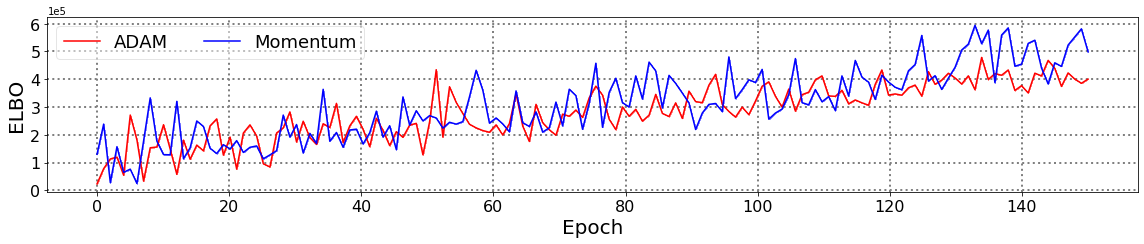

In [31]:
tsplotseveral(itera,[adam, adagrad], n=100)

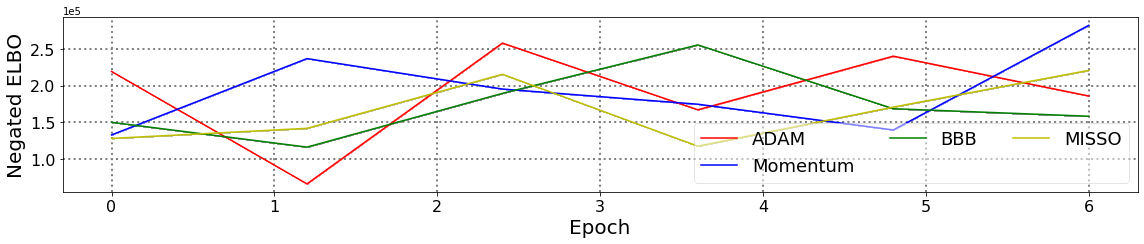

In [55]:
tsplotseveral(itera,[adam,adadelta,adagrad, rmsprop], n=100)